# Plot largest carbon sink hemisphere
- Author: Chenwei Xiao
- Date: Sep 23, 2023

1. plot two hemisphere and the cut line
2. calculation
3. show hemisphere plot

In [210]:
# basic
import numpy as np
import pandas as pd
import xarray as xr

## Plot hemisphere

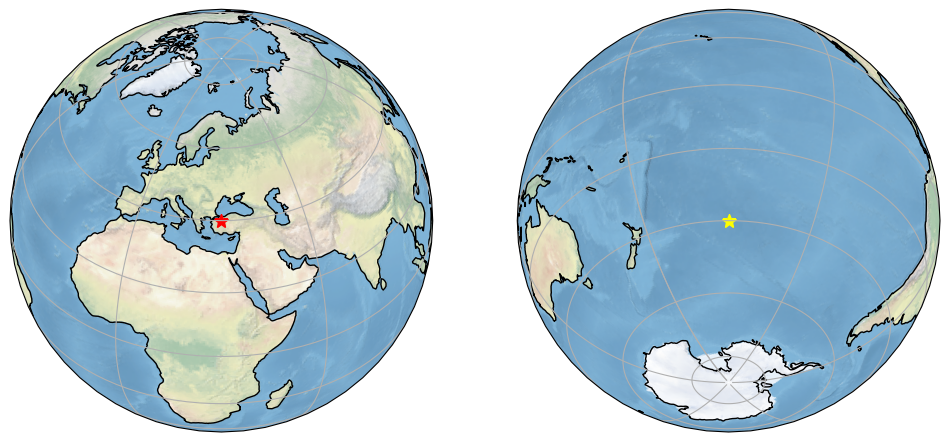

In [81]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat_t = 40
lon_t = 30

lat_c = -lat_t
lon_c = (lon_t+180) if lon_t<0 else (lon_t-180)

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1,2,1,projection=ccrs.Orthographic(central_longitude=lon_t, central_latitude=lat_t, globe=None))
ax2 = plt.subplot(1,2,2,projection=ccrs.Orthographic(central_longitude=lon_c, central_latitude=lat_c, globe=None))

for ax in (ax1,ax2):
    ax.coastlines(resolution='110m')
    ax.stock_img()
    ax.gridlines()

ax1.plot(lon_t, lat_t, marker='*', color='red', markersize=10, transform=ccrs.Orthographic(central_longitude=lon_t, central_latitude=lat_t, globe=None))
ax2.plot(lon_c, lat_c, marker='*', color='yellow', markersize=10, transform=ccrs.Orthographic(central_longitude=lon_c, central_latitude=lat_c, globe=None))

## Caculation

In [203]:
# take NEE in OCN model as an example 2021
nee_filepath = f"../data/raw/nee_2021.nc"
nee = xr.load_dataarray(nee_filepath)

In [204]:
nee2021 = nee.sum('time')

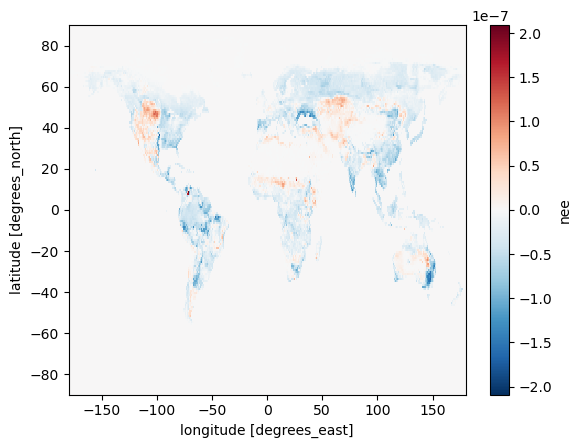

In [205]:
nee2021.plot()

In [206]:
# weighted by area
n_lon = nee2021.longitude.values.size
weights = np.cos(np.deg2rad(nee2021.latitude))
weights_nc = nee2021.copy()
weights_nc.data = np.tile(weights.values.T,(n_lon,1)).T

In [207]:
nee2021_weighted = nee2021*weights_nc

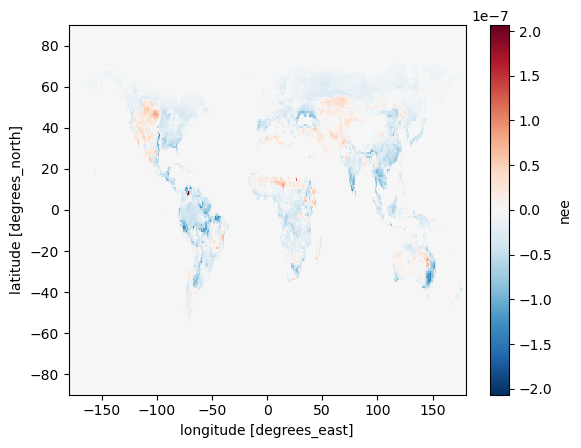

In [208]:
nee2021_weighted.plot()

In [209]:
nee2021_weighted.to_netcdf(f"../data/interm/nee_2021_weighted.nc")

In [137]:
# choose the target central pixel
lat_t = 40.5
lon_t = 30.5

In [188]:
# judge the angles
import math

def degrees_to_radians(degrees):
    return degrees * (math.pi / 180)

def spherical_to_cartesian(lat, lon):
    x = math.cos(lat) * math.cos(lon)
    y = math.cos(lat) * math.sin(lon)
    z = math.sin(lat)
    return x, y, z

def angle_between_points(lat1, lon1, lat2, lon2):
    lat1_rad = degrees_to_radians(lat1)
    lon1_rad = degrees_to_radians(lon1)
    lat2_rad = degrees_to_radians(lat2)
    lon2_rad = degrees_to_radians(lon2)

    x1, y1, z1 = spherical_to_cartesian(lat1_rad, lon1_rad)
    x2, y2, z2 = spherical_to_cartesian(lat2_rad, lon2_rad)

    dot_product = x1 * x2 + y1 * y2 + z1 * z2
    magnitude1 = math.sqrt(x1**2 + y1**2 + z1**2)
    magnitude2 = math.sqrt(x2**2 + y2**2 + z2**2)

    cos_theta = dot_product / (magnitude1 * magnitude2)
    # for very small error ignore
    if cos_theta > 1:
        cos_theta = 1
    elif cos_theta < -1:
        cos_theta = -1
    try:
        theta = math.acos(cos_theta)
    except:
        print(lat2)
        print(lon2)
        print(cos_theta)

    return theta

# Example Usage
lat1 = 37.7749
lon1 = -122.4194
lat2 = 40.7128
lon2 = -74.0060

angle = angle_between_points(lat1, lon1, lat2, lon2)
angle_degrees = math.degrees(angle)

print(f"The angle between the points is approximately {angle_degrees:.2f} degrees.")



The angle between the points is approximately 37.13 degrees.


In [189]:
# convert the globe to true, false nc file
# judge the hemisphere
# lat nc file
from tqdm.notebook import tqdm

def create_lat_lon_nc(nee2021):
    n_lat = nee2021.latitude.values.size
    n_lon = nee2021.longitude.values.size
    lat_nc = nee2021.copy()
    lat_nc.data = np.tile(nee2021.latitude.values.T,(n_lon,1)).T
    lon_nc = nee2021.copy()
    lon_nc.data = np.tile(nee2021.longitude.values,(n_lat,1))
    
    return lat_nc, lon_nc

# def angle_hemisphere()

def angle_hemisphere(nee2021, lat_t, lon_t):
    n_lat = nee2021.latitude.values.size
    n_lon = nee2021.longitude.values.size
    lat_nc, lon_nc = create_lat_lon_nc(nee2021)
    angle_nc = nee2021.copy()
    # angle_nc = angle_nc.stack(pix=('latitude','longitude'))
    # lat_nc = lat_nc.stack(pix=('latitude','longitude'))
    # lon_nc = lon_nc.stack(pix=('latitude','longitude'))
    for i in range(n_lat//2):
        for j in range(n_lon):
            angle = angle_between_points(lat1=lat_t, lon1=lon_t, lat2=lat_nc[i,j], lon2=lon_nc[i,j])
            angle_nc[i,j] = angle
            jc = j+n_lon//2 if j < n_lon//2 else j-n_lon//2
            angle_nc[n_lat-i-1,jc] = math.pi - angle
    
    return angle_nc

In [159]:
angle_nc = angle_hemisphere(nee2021, lat_t, lon_t)

In [160]:
hemis_nc = angle_nc - 0.5*math.pi

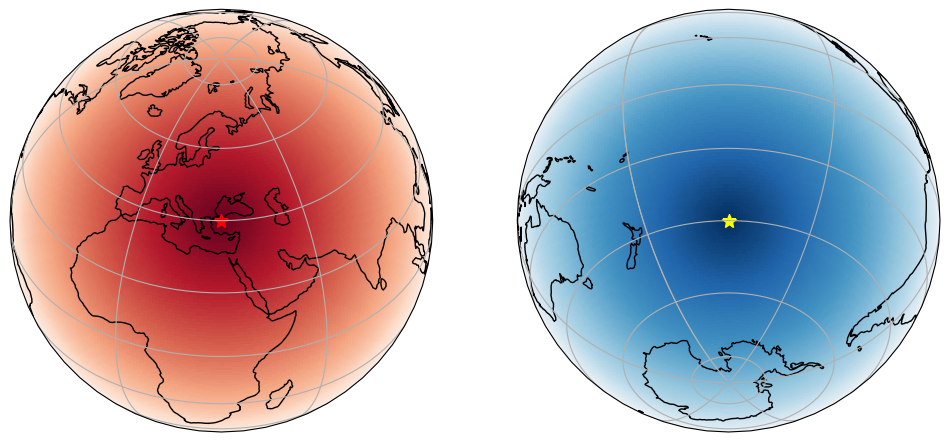

In [162]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat_t = 40
lon_t = 30

lat_c = -lat_t
lon_c = (lon_t+180) if lon_t<0 else (lon_t-180)

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1,2,1,projection=ccrs.Orthographic(central_longitude=lon_t, central_latitude=lat_t, globe=None))
ax2 = plt.subplot(1,2,2,projection=ccrs.Orthographic(central_longitude=lon_c, central_latitude=lat_c, globe=None))

for ax in (ax1,ax2):
    ax.coastlines(resolution='110m')
    ax.stock_img()
    ax.gridlines()

ax1.plot(lon_t, lat_t, marker='*', color='red', markersize=10, transform=ccrs.Orthographic(central_longitude=lon_t, central_latitude=lat_t, globe=None))
ax2.plot(lon_c, lat_c, marker='*', color='yellow', markersize=10, transform=ccrs.Orthographic(central_longitude=lon_c, central_latitude=lat_c, globe=None))

# Plot True values in blue
ax1.pcolormesh(hemis_nc.longitude, hemis_nc.latitude, hemis_nc, cmap='RdBu', transform=ccrs.PlateCarree())
ax2.pcolormesh(hemis_nc.longitude, hemis_nc.latitude, hemis_nc, cmap='RdBu', transform=ccrs.PlateCarree())

## Start to calculate sum hemisphere for globe

In [163]:
nee_t = nee2021_weighted.where(angle_nc <= 0.5*math.pi).sum()

In [195]:
# start to calculate for each pixel now take long time
def nee_hemis_calc(nee2021_weighted):
    n_lat = nee2021_weighted.latitude.values.size
    n_lon = nee2021_weighted.longitude.values.size
    nee_hemis = xr.full_like(nee2021_weighted, -999)
    for i in tqdm(range(n_lat//2)):
        for j in range(n_lon//360):
            lat_t = nee_hemis[i,j].latitude.values
            lon_t = nee_hemis[i,j].longitude.values
            angle_nc = angle_hemisphere(nee2021_weighted, lat_t, lon_t)
            nee_hemis[i,j] = nee2021_weighted.where(angle_nc <= 0.5*math.pi).sum()
            jc = j+n_lon//2 if j < n_lon//2 else j-n_lon//2
            nee_hemis[n_lat-i-1,jc] = nee2021_weighted.where(angle_nc >= 0.5*math.pi).sum()

    return nee_hemis

In [ ]:
nee_hemis_test = nee_hemis_calc(nee2021_weighted)

In [218]:
# read results merged by cdo
nee_hemis_sum = xr.load_dataarray(f'../data/processed/nee_hemis.out.globe.nc')

In [219]:
nee_hemis_sum = nee_hemis_sum.where(nee_hemis_sum!= -999)

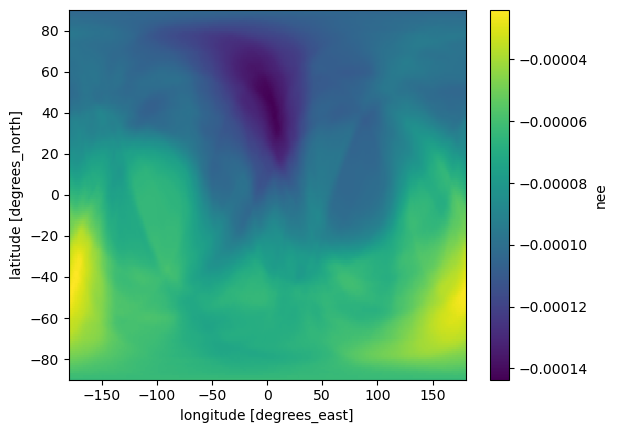

In [220]:
nee_hemis_sum.plot()

In [223]:
# find the largest carbon sink center
nee_hemis_sum_max_sink = nee_hemis_sum.where(nee_hemis_sum == nee_hemis_sum.min(), drop=True)

In [228]:
nee_hemis_sum_max_sink[0,0]

<xarray.DataArray 'nee' ()>
array(-0.00014362)
Coordinates:
    longitude  float64 6.5
    latitude   float64 38.5

In [ ]:
# plot the hemisphere

In [232]:
nee_hemis_sum_max_sink.latitude[0].values

array(38.5)

Text(0.5, 1.0, 'Largest Carbon Sink Pole [Carbon Sink = -1.44e-04 kg m^-2 s^-1]')

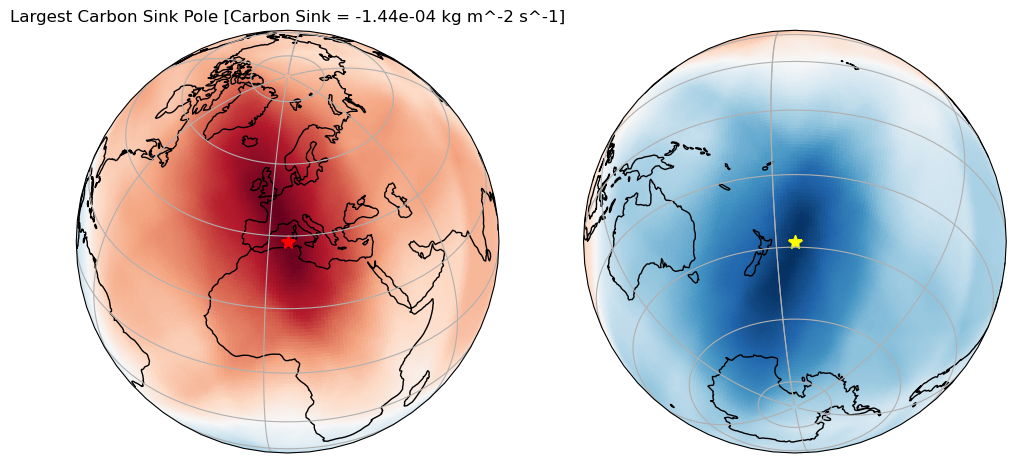

In [233]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lat_t = nee_hemis_sum_max_sink.latitude[0].values
lon_t = nee_hemis_sum_max_sink.longitude[0].values

lat_c = -lat_t
lon_c = (lon_t+180) if lon_t<0 else (lon_t-180)

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1,2,1,projection=ccrs.Orthographic(central_longitude=lon_t, central_latitude=lat_t, globe=None))
ax2 = plt.subplot(1,2,2,projection=ccrs.Orthographic(central_longitude=lon_c, central_latitude=lat_c, globe=None))

for ax in (ax1,ax2):
    ax.coastlines(resolution='110m')
    ax.stock_img()
    ax.gridlines()

ax1.plot(lon_t, lat_t, marker='*', color='red', markersize=10, transform=ccrs.Orthographic(central_longitude=lon_t, central_latitude=lat_t, globe=None))
ax2.plot(lon_c, lat_c, marker='*', color='yellow', markersize=10, transform=ccrs.Orthographic(central_longitude=lon_c, central_latitude=lat_c, globe=None))

# Plot True values in blue
ax1.pcolormesh(nee_hemis_sum.longitude, nee_hemis_sum.latitude, nee_hemis_sum, cmap='RdBu', transform=ccrs.PlateCarree())
ax2.pcolormesh(nee_hemis_sum.longitude, nee_hemis_sum.latitude, nee_hemis_sum, cmap='RdBu', transform=ccrs.PlateCarree())

ax1.set_title('Largest Carbon Sink Pole [Carbon Sink = {:.2e} kg m^-2 s^-1]'.format(nee_hemis_sum_max_sink[0,0].values))